In [1]:
# Cell 1 - imports & settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style='whitegrid')

In [2]:
# Cell 2 - load and peek
df = pd.read_csv('diabetes.csv')   # change path if needed
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe().T)

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   Pedigree       768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Target value counts:
 Outcome
0    500
1    268
Name: count, dtype: int64


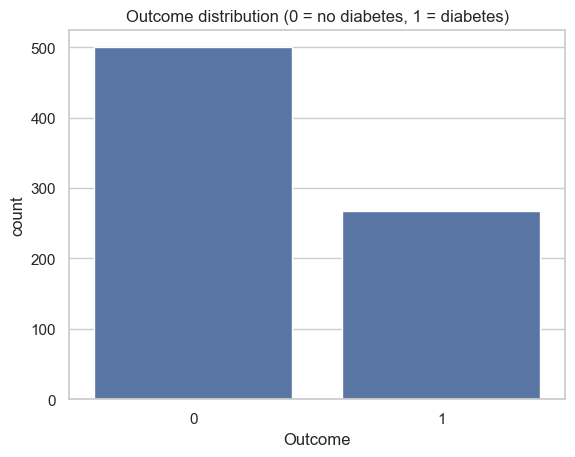

Zero counts in selected columns:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [3]:
# Cell 3 - EDA
# Target column typically 'Outcome' (1 = diabetes, 0 = no diabetes)
print("Target value counts:\n", df['Outcome'].value_counts())
sns.countplot(x='Outcome', data=df)
plt.title('Outcome distribution (0 = no diabetes, 1 = diabetes)')
plt.show()

# Check for zeros in columns that shouldn't be zero (Pima dataset)
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print("Zero counts in selected columns:")
print((df[zero_cols] == 0).sum())

In [4]:
# Cell 4 - preprocessing
# Replace zeros in selected columns with NaN (so we can impute)
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)

# Simple imputation: replace NaN with median (robust)
for c in zero_cols:
    median_val = df[c].median()
    df[c].fillna(median_val, inplace=True)

# Features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

print("Final shapes -> X:", X.shape, "y:", y.shape)
display(X.head())

Final shapes -> X: (768, 8) y: (768,)


C:\Users\Asus\AppData\Local\Temp\ipykernel_6412\49446507.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(median_val, inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_6412\49446507.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [5]:
# Cell 5 - split + scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape, "Test shape:", X_test_scaled.shape)

Train shape: (614, 8) Test shape: (154, 8)


In [6]:
# Cell 6 - tune k using GridSearchCV (search odd k's)
param_grid = {'n_neighbors': list(range(1, 31, 2))}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best n_neighbors:", grid.best_params_['n_neighbors'])
print("Best CV accuracy:", grid.best_score_)
best_k = grid.best_params_['n_neighbors']

Best n_neighbors: 19
Best CV accuracy: 0.7769025723044115


In [7]:
# Cell 7 - train final model
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)
y_proba = knn_final.predict_proba(X_test_scaled)[:,1]   # if needed

Confusion Matrix:
 [[85 15]
 [24 30]]

Accuracy: 0.7468
Error Rate: 0.2532
Precision: 0.6667
Recall: 0.5556

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



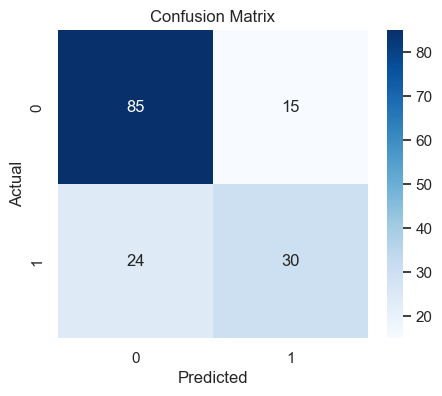

In [8]:
# Cell 8 - evaluation metrics
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
error_rate = 1 - acc
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print(f"\nAccuracy: {acc:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

print("\nClassification Report:\n", report)

# Pretty confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Cross-validated train accuracy (5-fold): 0.7769
Test ROC-AUC: 0.8077


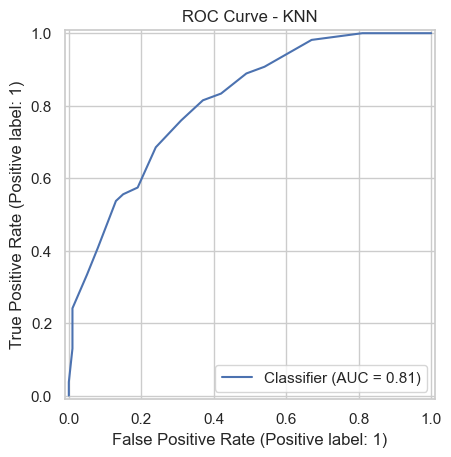

In [9]:
# Cell 9 - optional extra metrics
cv_acc = cross_val_score(knn_final, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
from sklearn.metrics import roc_auc_score, RocCurveDisplay
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Cross-validated train accuracy (5-fold): {cv_acc:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve - KNN')
plt.show()